# INFO 2950 Final Project Phase II  
Mary Kolbas (mck86)  
Tammy Zhang (tz332)  


In [53]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import duckdb, sqlalchemy

In [54]:
%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [55]:
# reading in raw provided data
csv = pd.read_csv("PFW_2021_public.csv")

In [56]:
# making dataframe
df = pd.DataFrame(csv)

In [57]:
# dropping irrelevant columns
df.drop(['latitude', 'longitude', 'entry_technique', 'PROJ_PERIOD_ID', 'reviewed', 'day1_am', 'sub_id', 'obs_id',
        'day1_pm', 'day2_am', 'day2_pm', 'effort_hrs_atleast', 'Data_Entry_Method'], axis= 1, inplace= True)

In [58]:
# dropping observations outside of NY
df = df[df['subnational1_code'] == "US-NY"]

# dropping observations that are not valid
df = df[df['valid'] == 1]

In [59]:
df

,loc_id,subnational1_code,Month,Day,Year,species_code,how_many,valid,snow_dep_atleast
9808,L6731705,US-NY,11,14,2020,blujay,1,1,0.000
9809,L6731705,US-NY,11,14,2020,norcar,1,1,0.000
9810,L6731705,US-NY,11,14,2020,dowwoo,1,1,0.000
9811,L6731705,US-NY,11,14,2020,tuftit,2,1,0.000
9812,L6731705,US-NY,11,14,2020,bkcchi,2,1,0.000
...,...,...,...,...,...,...,...,...,...
2897100,L2404002,US-NY,2,10,2021,daejun,3,1,0.001
2897101,L2404002,US-NY,2,10,2021,amerob,1,1,0.001
2897102,L2404002,US-NY,2,10,2021,houfin,11,1,0.001
2897103,L2404002,US-NY,2,10,2021,norcar,5,1,0.001


In [60]:
# joining common names
species_translate_df = pd.DataFrame(pd.read_csv("PFW-species-translation-table.csv"))
%sql df << SELECT loc_id, Month, Day, Year, df.species_code, how_many, snow_dep_atleast, scientific_name, american_english_name FROM df INNER JOIN species_translate_df ON df.species_code = species_translate_df.species_code;
df[['genus','species']] = df['scientific_name'].str.split(expand=True).iloc[:, :2]

Returning data to local variable df


In [61]:
df

,loc_id,Month,Day,Year,species_code,how_many,snow_dep_atleast,scientific_name,american_english_name,genus,species
0,L6731705,11,14,2020,blujay,1,0.000,Cyanocitta cristata,Blue Jay,Cyanocitta,cristata
1,L6731705,11,14,2020,norcar,1,0.000,Cardinalis cardinalis,Northern Cardinal,Cardinalis,cardinalis
2,L6731705,11,14,2020,tuftit,2,0.000,Baeolophus bicolor,Tufted Titmouse,Baeolophus,bicolor
3,L6731705,11,14,2020,bkcchi,2,0.000,Poecile atricapillus,Black-capped Chickadee,Poecile,atricapillus
4,L6731705,11,14,2020,whbnut,1,0.000,Sitta carolinensis,White-breasted Nuthatch,Sitta,carolinensis
...,...,...,...,...,...,...,...,...,...,...,...
246003,L6230037,11,21,2020,dowwoo,1,0.000,Dryobates pubescens,Downy Woodpecker,Dryobates,pubescens
246004,L6230037,12,5,2020,dowwoo,1,0.001,Dryobates pubescens,Downy Woodpecker,Dryobates,pubescens
246005,L6230037,12,12,2020,dowwoo,2,0.001,Dryobates pubescens,Downy Woodpecker,Dryobates,pubescens
246006,L1153472,2,10,2021,dowwoo,2,5.000,Dryobates pubescens,Downy Woodpecker,Dryobates,pubescens


In [62]:
# making a list of the 25 most frequently observed species
frequent_species = df['species_code'].value_counts()[:25].index

In [63]:
def snow_depth_species(species):
    """
    Returns: mean observed counts for the given species grouped by amount of snow.
    
    Parameter species: a string constituting a valid 6-letter avian species code.
    """
    species_df = df[df['species_code'] == species]
    species_df = species_df.dropna(subset=['snow_dep_atleast'])
    
    print('Snow Depth and Observations of ' + species)
    print(species_df.groupby(by=['snow_dep_atleast']).mean()['how_many'])

In [64]:
# Uncomment below to print out grouped averages for all top frequent species
# for species in frequent_species:
#     snow_depth_species(species)

In [65]:
# creating new dataframe limited to just the most frequent species observations
species_limited_df = df[df['species_code'].isin(frequent_species)]

# dropping rows where snow depth was null
species_limited_df = species_limited_df.dropna(subset=['snow_dep_atleast'])

In [66]:
species_limited_df

,loc_id,Month,Day,Year,species_code,how_many,snow_dep_atleast,scientific_name,american_english_name,genus,species
0,L6731705,11,14,2020,blujay,1,0.000,Cyanocitta cristata,Blue Jay,Cyanocitta,cristata
1,L6731705,11,14,2020,norcar,1,0.000,Cardinalis cardinalis,Northern Cardinal,Cardinalis,cardinalis
2,L6731705,11,14,2020,tuftit,2,0.000,Baeolophus bicolor,Tufted Titmouse,Baeolophus,bicolor
3,L6731705,11,14,2020,bkcchi,2,0.000,Poecile atricapillus,Black-capped Chickadee,Poecile,atricapillus
4,L6731705,11,14,2020,whbnut,1,0.000,Sitta carolinensis,White-breasted Nuthatch,Sitta,carolinensis
...,...,...,...,...,...,...,...,...,...,...,...
246002,L5054277,4,28,2021,dowwoo,1,0.000,Dryobates pubescens,Downy Woodpecker,Dryobates,pubescens
246003,L6230037,11,21,2020,dowwoo,1,0.000,Dryobates pubescens,Downy Woodpecker,Dryobates,pubescens
246004,L6230037,12,5,2020,dowwoo,1,0.001,Dryobates pubescens,Downy Woodpecker,Dryobates,pubescens
246005,L6230037,12,12,2020,dowwoo,2,0.001,Dryobates pubescens,Downy Woodpecker,Dryobates,pubescens


In [67]:
# creating new category with string corresponding to each value in snow depth (for binning in the line plots)
species_limited_df['snow_category'] = 'No Snow'
species_limited_df.loc[species_limited_df['snow_dep_atleast'] == 0.001, 'snow_category'] = '< 5 cm'
species_limited_df.loc[species_limited_df['snow_dep_atleast'] == 5.000, 'snow_category'] = '5 to 15 cm'
species_limited_df.loc[species_limited_df['snow_dep_atleast'] == 15.001, 'snow_category'] = '> 15 cm'

In [68]:
species_limited_df

,loc_id,Month,Day,Year,species_code,how_many,snow_dep_atleast,scientific_name,american_english_name,genus,species,snow_category
0,L6731705,11,14,2020,blujay,1,0.000,Cyanocitta cristata,Blue Jay,Cyanocitta,cristata,No Snow
1,L6731705,11,14,2020,norcar,1,0.000,Cardinalis cardinalis,Northern Cardinal,Cardinalis,cardinalis,No Snow
2,L6731705,11,14,2020,tuftit,2,0.000,Baeolophus bicolor,Tufted Titmouse,Baeolophus,bicolor,No Snow
3,L6731705,11,14,2020,bkcchi,2,0.000,Poecile atricapillus,Black-capped Chickadee,Poecile,atricapillus,No Snow
4,L6731705,11,14,2020,whbnut,1,0.000,Sitta carolinensis,White-breasted Nuthatch,Sitta,carolinensis,No Snow
...,...,...,...,...,...,...,...,...,...,...,...,...
246002,L5054277,4,28,2021,dowwoo,1,0.000,Dryobates pubescens,Downy Woodpecker,Dryobates,pubescens,No Snow
246003,L6230037,11,21,2020,dowwoo,1,0.000,Dryobates pubescens,Downy Woodpecker,Dryobates,pubescens,No Snow
246004,L6230037,12,5,2020,dowwoo,1,0.001,Dryobates pubescens,Downy Woodpecker,Dryobates,pubescens,< 5 cm
246005,L6230037,12,12,2020,dowwoo,2,0.001,Dryobates pubescens,Downy Woodpecker,Dryobates,pubescens,< 5 cm


In [69]:
# creating plotting function
def plot_by_species(df):
    # grouping by species and snow, averaging counts for each species per snow category
    average = df.groupby(by=['species_code', 'snow_category']).mean()
    average = average.reindex(index = ['No Snow','< 5 cm','5 to 15 cm', '> 15 cm'], level = 1)
    fig = plt.gcf()
    fig.set_size_inches(14, 8)
    ax = sns.lineplot(data = average, x = average.index.get_level_values(1).to_list(), y = average['how_many'], hue='species_code', marker='o').set(title="Avian Species at Feeders with Different Snow Levels")
    plt.legend(loc = "upper left", bbox_to_anchor=(1, 1))
    return ax

[Text(0.5, 1.0, 'Avian Species at Feeders with Different Snow Levels')]

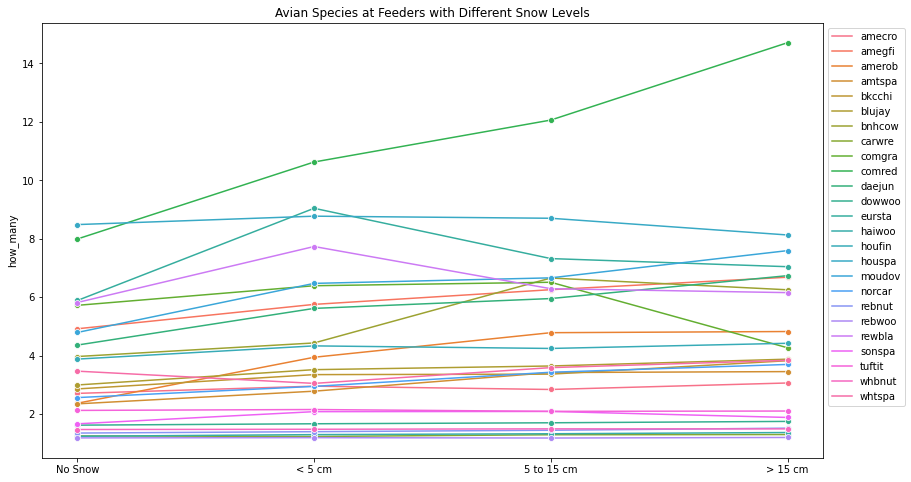

In [70]:
plot_by_species(species_limited_df)

[Text(0.5, 1.0, 'Avian Species at Feeders with Different Snow Levels')]

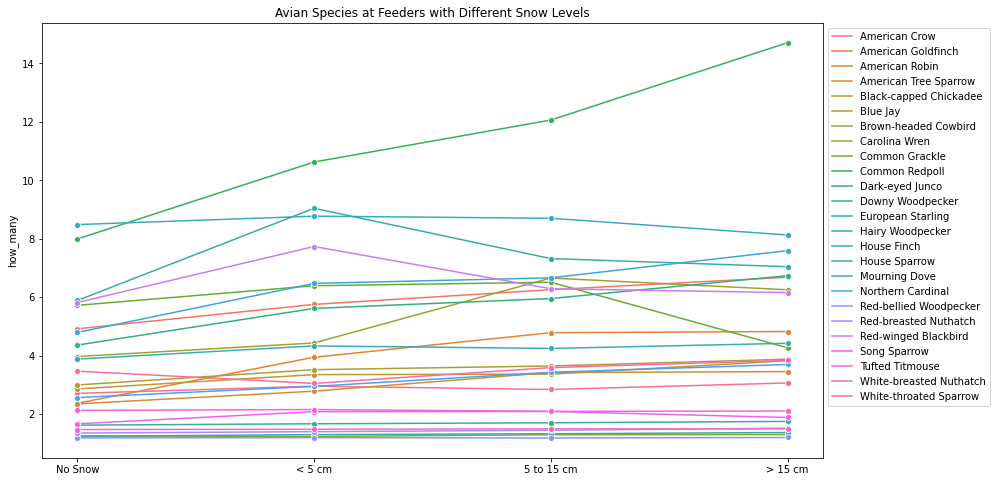

In [71]:
def plot_by_species_name(df):
    # grouping by species and snow, averaging counts for each species per snow category; using common name
    average = df.groupby(by=['american_english_name', 'snow_category']).mean()
    average = average.reindex(index = ['No Snow','< 5 cm','5 to 15 cm', '> 15 cm'], level = 1)
    fig = plt.gcf()
    fig.set_size_inches(14, 8)
    ax = sns.lineplot(data = average, x = average.index.get_level_values(1).to_list(), y = average['how_many'], hue='american_english_name', marker='o').set(title="Avian Species at Feeders with Different Snow Levels")
    plt.legend(loc = "upper left", bbox_to_anchor=(1, 1))
    return ax
plot_by_species_name(species_limited_df)

## time trends

In [72]:
#create a dataframe that groups by time
import datetime as dt

species_limited_time = species_limited_df

# create a column that puts month, date, year in one string
species_limited_time['datestring'] = species_limited_time['Month'].astype(str) + "/" + species_limited_time['Day'].astype(str) + "/" + species_limited_time['Year'].astype(str)

#turn datestring into datetime and drop datestring
species_limited_time['date_time'] = pd.to_datetime(species_limited_time['datestring'], format='%m/%d/%Y')
species_limited_time.drop(columns="datestring")
species_limited_time

,loc_id,Month,Day,Year,species_code,how_many,snow_dep_atleast,scientific_name,american_english_name,genus,species,snow_category,datestring,date_time
0,L6731705,11,14,2020,blujay,1,0.000,Cyanocitta cristata,Blue Jay,Cyanocitta,cristata,No Snow,11/14/2020,2020-11-14
1,L6731705,11,14,2020,norcar,1,0.000,Cardinalis cardinalis,Northern Cardinal,Cardinalis,cardinalis,No Snow,11/14/2020,2020-11-14
2,L6731705,11,14,2020,tuftit,2,0.000,Baeolophus bicolor,Tufted Titmouse,Baeolophus,bicolor,No Snow,11/14/2020,2020-11-14
3,L6731705,11,14,2020,bkcchi,2,0.000,Poecile atricapillus,Black-capped Chickadee,Poecile,atricapillus,No Snow,11/14/2020,2020-11-14
4,L6731705,11,14,2020,whbnut,1,0.000,Sitta carolinensis,White-breasted Nuthatch,Sitta,carolinensis,No Snow,11/14/2020,2020-11-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246002,L5054277,4,28,2021,dowwoo,1,0.000,Dryobates pubescens,Downy Woodpecker,Dryobates,pubescens,No Snow,4/28/2021,2021-04-28
246003,L6230037,11,21,2020,dowwoo,1,0.000,Dryobates pubescens,Downy Woodpecker,Dryobates,pubescens,No Snow,11/21/2020,2020-11-21
246004,L6230037,12,5,2020,dowwoo,1,0.001,Dryobates pubescens,Downy Woodpecker,Dryobates,pubescens,< 5 cm,12/5/2020,2020-12-05
246005,L6230037,12,12,2020,dowwoo,2,0.001,Dryobates pubescens,Downy Woodpecker,Dryobates,pubescens,< 5 cm,12/12/2020,2020-12-12


In [73]:
species_limited_time = species_limited_time.groupby(["species_code", "date_time"]).mean()
species_limited_time

Month   Day    Year  how_many  snow_dep_atleast
species_code date_time                                                  
amecro       2020-11-14   11.0  14.0  2020.0  3.613333          0.000013
             2020-11-15   11.0  15.0  2020.0  2.916667          0.000083
             2020-11-16   11.0  16.0  2020.0  6.555556          0.000111
             2020-11-17   11.0  17.0  2020.0  2.400000          0.667000
             2020-11-18   11.0  18.0  2020.0  3.555556          0.000667
...                        ...   ...     ...       ...               ...
whtspa       2021-04-25    4.0  25.0  2021.0  4.133333          0.000000
             2021-04-26    4.0  26.0  2021.0  2.764706          0.000000
             2021-04-27    4.0  27.0  2021.0  5.325000          0.000000
             2021-04-28    4.0  28.0  2021.0  4.041667          0.000000
             2021-04-29    4.0  29.0  2021.0  4.928571          0.000071

[4114 rows x 5 columns]

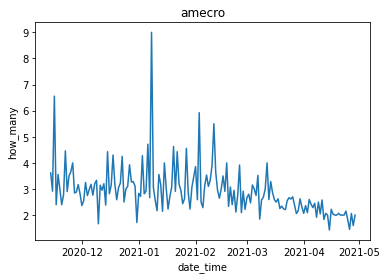

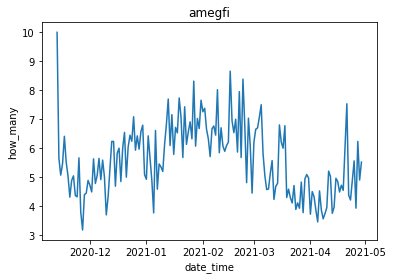

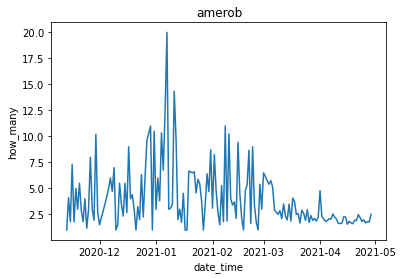

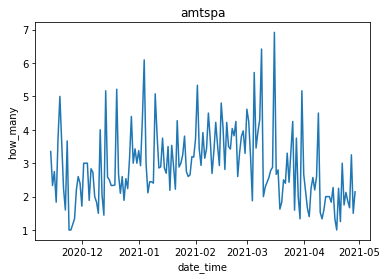

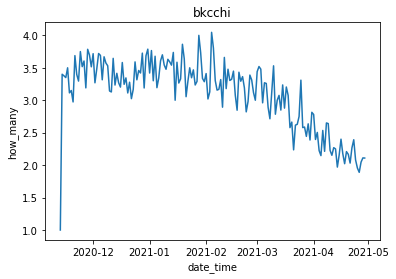

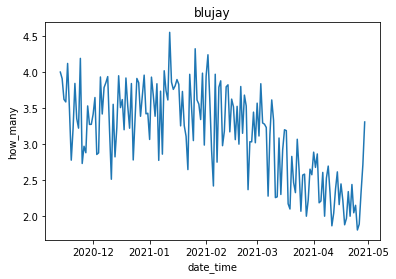

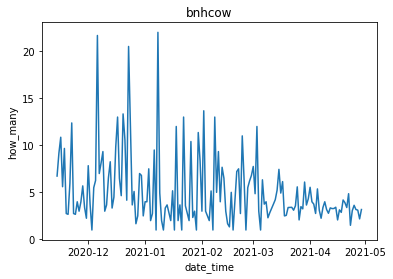

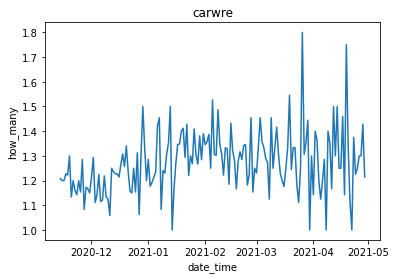

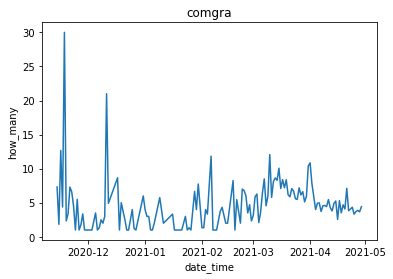

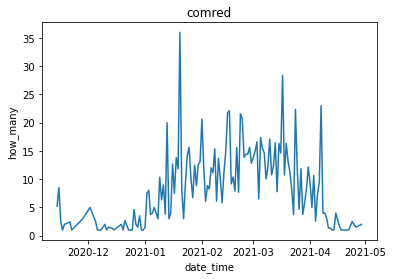

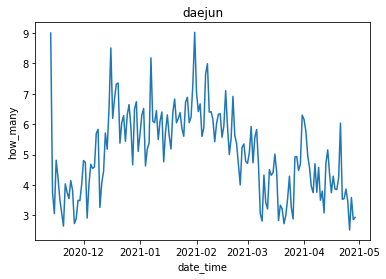

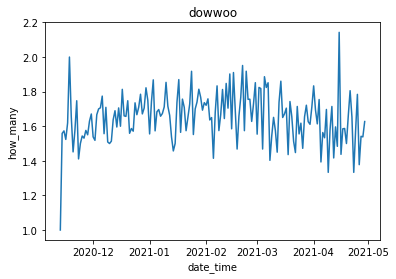

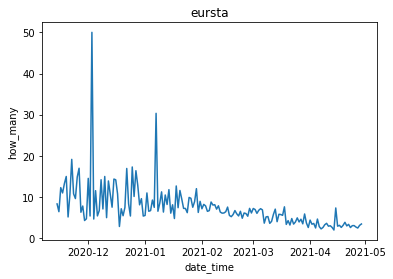

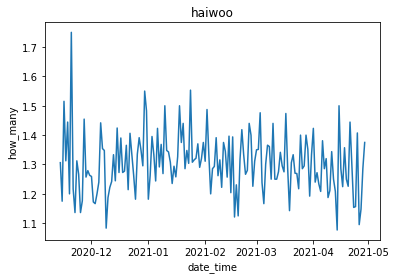

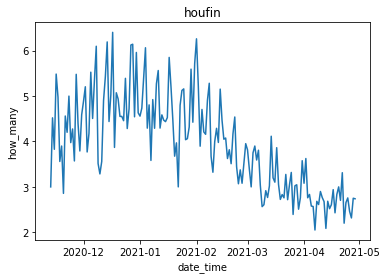

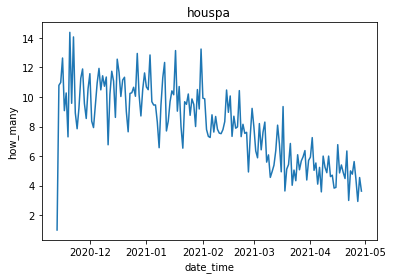

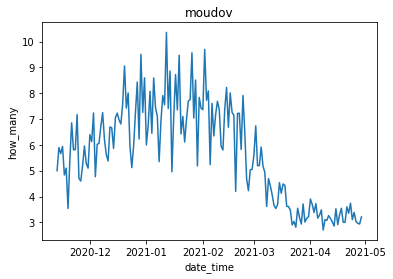

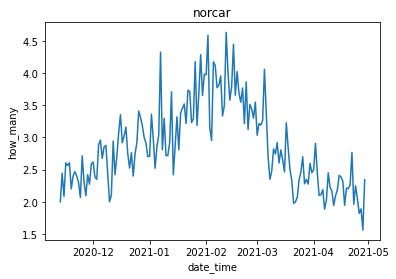

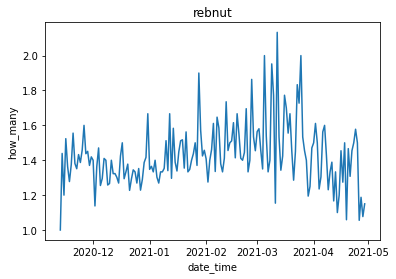

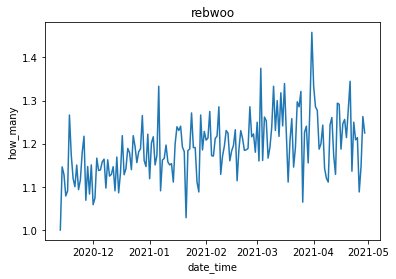

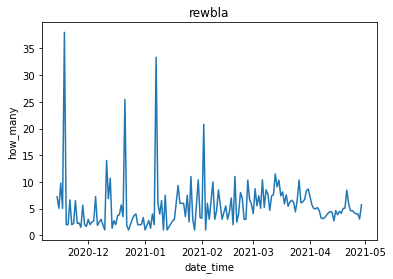

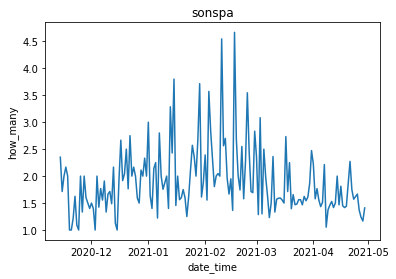

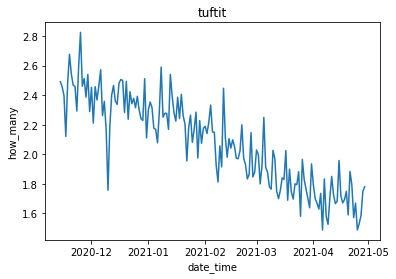

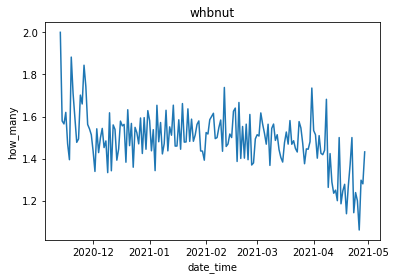

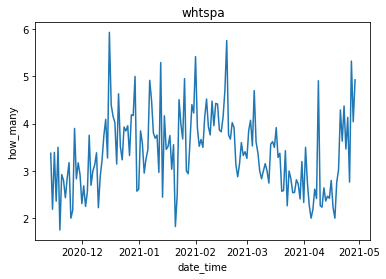

""


In [74]:
#creating plotting function to plot each species in df over time
def plot_by_year(df):
    g = sns.lineplot(x="date_time", y="how_many", data=df)
    ax = plt.gca()
    ax.set_title(str(df.index[0][0]))
    plt.show()
species_limited_time.groupby("species_code").apply(plot_by_year)

In [75]:
#grouping by month, but months 5-10 are not present in the data, making it hard to graph
species_limited_month = species_limited_time.reset_index().groupby(['Month', 'species_code']).mean()[['how_many']]
species_limited_month

how_many
Month species_code          
1.0   amecro        3.322830
      amegfi        6.302336
      amerob        5.767161
      amtspa        3.195116
      bkcchi        3.475997
...                      ...
12.0  rewbla        4.351301
      sonspa        1.817178
      tuftit        2.341377
      whbnut        1.492777
      whtspa        3.523584

[150 rows x 1 columns]

In [76]:
#creating plotting function to plot each species in species_limited_month per month
# def plot_months(df):
#     g = sns.scatterplot(x="Month", y="how_many", data=df, hue='species_code')
#     ax = plt.gca()
#     ax.set_title("Birds over months")
#     plt.legend(loc = "upper left", bbox_to_anchor=(1, 1))
#     plt.show()
# plot_months(species_limited_month)

##doesn't work well or as intended because months 5-10 are not present in the data

## top 25 species by sighting time (morning vs. afternoon/evening)

In [77]:
#create new dataframe
df_timeofday = pd.DataFrame(csv)

#same as df, but keeping day1 and day2 am/pm
df_timeofday.drop(['latitude', 'longitude', 'entry_technique', 'PROJ_PERIOD_ID', 'reviewed', 'sub_id', 'obs_id',
       'effort_hrs_atleast', 'Data_Entry_Method'], axis= 1, inplace= True)

# dropping observations outside of NY
df_timeofday = df_timeofday[df_timeofday['subnational1_code'] == "US-NY"]

# dropping observations that are not valid
df_timeofday = df_timeofday[df_timeofday['valid'] == 1]

#grab all entries where the sighting only occured at one of the 4 periods of the 2-day sighting period 
df_timeofday = df_timeofday[df_timeofday['day1_am'] + df_timeofday['day1_pm'] + df_timeofday['day2_am'] + df_timeofday['day2_pm'] == 1]

#only top 25 species
df_timeofday_specieslimited = df_timeofday[df_timeofday['species_code'].isin(frequent_species)]

df_timeofday_specieslimited

,loc_id,subnational1_code,Month,Day,Year,species_code,how_many,valid,day1_am,day1_pm,day2_am,day2_pm,snow_dep_atleast
401014,L14097411,US-NY,3,20,2021,moudov,2,1,0,0,1,0,0.000
401015,L14097411,US-NY,3,20,2021,norcar,2,1,0,0,1,0,0.000
401016,L14097411,US-NY,3,20,2021,rebwoo,2,1,0,0,1,0,0.000
401017,L14097411,US-NY,3,20,2021,comred,5,1,0,0,1,0,0.000
401018,L14097411,US-NY,3,20,2021,dowwoo,2,1,0,0,1,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2897100,L2404002,US-NY,2,10,2021,daejun,3,1,0,0,1,0,0.001
2897101,L2404002,US-NY,2,10,2021,amerob,1,1,0,0,1,0,0.001
2897102,L2404002,US-NY,2,10,2021,houfin,11,1,0,0,1,0,0.001
2897103,L2404002,US-NY,2,10,2021,norcar,5,1,0,0,1,0,0.001


In [78]:
# creating new category with string corresponding to unique sighting day1_am, day1_pm, day2_am, day2_pm
df_timeofday_specieslimited['unique_time'] = 'day1_am'
df_timeofday_specieslimited.loc[df_timeofday_specieslimited['day1_pm'] == 1, 'unique_time'] = 'day1_pm'
df_timeofday_specieslimited.loc[df_timeofday_specieslimited['day2_am'] == 1, 'unique_time'] = 'day2_am'
df_timeofday_specieslimited.loc[df_timeofday_specieslimited['day2_pm'] == 1, 'unique_time'] = 'day2_pm'
df_timeofday_specieslimited.head()

C:\Users\mkolb\AppData\Local\Temp\ipykernel_12348\1648513741.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_timeofday_specieslimited['unique_time'] = 'day1_am'


,loc_id,subnational1_code,Month,Day,Year,species_code,how_many,valid,day1_am,day1_pm,day2_am,day2_pm,snow_dep_atleast,unique_time
401014,L14097411,US-NY,3,20,2021,moudov,2,1,0,0,1,0,0.0,day2_am
401015,L14097411,US-NY,3,20,2021,norcar,2,1,0,0,1,0,0.0,day2_am
401016,L14097411,US-NY,3,20,2021,rebwoo,2,1,0,0,1,0,0.0,day2_am
401017,L14097411,US-NY,3,20,2021,comred,5,1,0,0,1,0,0.0,day2_am
401018,L14097411,US-NY,3,20,2021,dowwoo,2,1,0,0,1,0,0.0,day2_am


In [79]:
# creating plotting function
def plot_uniquetime(df):
    # grouping by species and unique_time, averaging counts for each species per time category
    average = df.groupby(by=['species_code', 'unique_time']).mean()
    average = average.reindex(index = ['day1_am','day2_am', 'day1_pm', 'day2_pm'], level = 1)
    fig = plt.gcf()
    fig.set_size_inches(14, 8)
    ax = sns.lineplot(data = average, x = average.index.get_level_values(1).to_list(), y = average['how_many'], hue='species_code', marker='o').set(title="Avian Species at Feeders at different sighting times")
    plt.legend(loc = "upper left", bbox_to_anchor=(1, 1))
    return ax

[Text(0.5, 1.0, 'Avian Species at Feeders at different sighting times')]

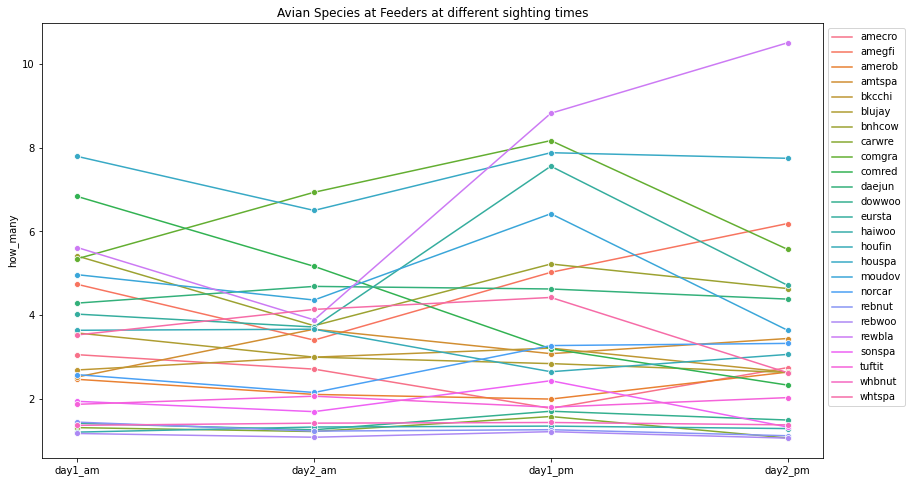

In [80]:
plot_uniquetime(df_timeofday_specieslimited)

## Reading in site data

In [81]:
# reading in raw provided data
csv_sites = pd.read_csv("PFW_count_site_data_public_2021.csv")

#creating dataframe
sites_df = pd.DataFrame(csv_sites)

sites_df.head()

,loc_id,proj_period_id,yard_type_pavement,yard_type_garden,yard_type_landsca,yard_type_woods,yard_type_desert,hab_dcid_woods,hab_evgr_woods,hab_mixed_woods,hab_orchard,hab_park,hab_water_fresh,hab_water_salt,hab_residential,hab_industrial,hab_agricultural,hab_desert_scrub,hab_young_woods,hab_swamp,hab_marsh,evgr_trees_atleast,evgr_shrbs_atleast,dcid_trees_atleast,dcid_shrbs_atleast,fru_trees_atleast,cacti_atleast,brsh_piles_atleast,water_srcs_atleast,bird_baths_atleast,nearby_feeders,squirrels,cats,dogs,humans,housing_density,fed_yr_round,fed_in_jan,fed_in_feb,fed_in_mar,fed_in_apr,fed_in_may,fed_in_jun,fed_in_jul,fed_in_aug,fed_in_sep,fed_in_oct,fed_in_nov,fed_in_dec,numfeeders_suet,numfeeders_ground,numfeeders_hanging,numfeeders_platfrm,numfeeders_humming,numfeeders_water,numfeeders_thistle,numfeeders_fruit,numfeeders_hopper,numfeeders_tube,numfeeders_other,population_atleast,count_area_size_sq_m_atleast
0,L100016,PFW_2002,0.0,0.0,1.0,0.0,0.0,1.0,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,11.0,4.0,11.0,4.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.01
1,L100016,PFW_2003,0.0,0.0,1.0,0.0,0.0,1.0,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,11.0,4.0,11.0,4.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,1.0,1.01
2,L100016,PFW_2004,0.0,0.0,1.0,0.0,0.0,1.0,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,11.0,4.0,11.0,4.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,1.0,1.01
3,L100016,PFW_2005,0.0,0.0,1.0,0.0,0.0,1.0,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,11.0,4.0,11.0,4.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,1.0,1.01
4,L100016,PFW_2006,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,11.0,1.0,1.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,1.01


In [82]:
print("sites_df size: ", sites_df.size)
sites_df.columns

sites_df size:  15770010


Index(['loc_id', 'proj_period_id', 'yard_type_pavement', 'yard_type_garden',
       'yard_type_landsca', 'yard_type_woods', 'yard_type_desert',
       'hab_dcid_woods', 'hab_evgr_woods', 'hab_mixed_woods', 'hab_orchard',
       'hab_park', 'hab_water_fresh', 'hab_water_salt', 'hab_residential',
       'hab_industrial', 'hab_agricultural', 'hab_desert_scrub',
       'hab_young_woods', 'hab_swamp', 'hab_marsh', 'evgr_trees_atleast',
       'evgr_shrbs_atleast', 'dcid_trees_atleast', 'dcid_shrbs_atleast',
       'fru_trees_atleast', 'cacti_atleast', 'brsh_piles_atleast',
       'water_srcs_atleast', 'bird_baths_atleast', 'nearby_feeders',
       'squirrels', 'cats', 'dogs', 'humans', 'housing_density',
       'fed_yr_round', 'fed_in_jan', 'fed_in_feb', 'fed_in_mar', 'fed_in_apr',
       'fed_in_may', 'fed_in_jun', 'fed_in_jul', 'fed_in_aug', 'fed_in_sep',
       'fed_in_oct', 'fed_in_nov', 'fed_in_dec', 'numfeeders_suet',
       'numfeeders_ground', 'numfeeders_hanging', 'numfeeders_platf

## Joining sightings and site data

In [52]:
#join species_limited_df (sightings of top 25 species) with sites_df (location details)
#%sql join_df << SELECT species_limited_df.loc_id, species_code, how_many, snow_dep_atleast, snow_category,  date_time, proj_period_id, yard_type_pavement, yard_type_garden, yard_type_landsca, yard_type_woods, yard_type_desert,hab_dcid_woods, hab_evgr_woods, hab_mixed_woods, hab_orchard, hab_park, hab_water_fresh, hab_water_salt, hab_residential,hab_industrial, hab_agricultural, hab_desert_scrub, hab_young_woods, hab_swamp, hab_marsh, evgr_trees_atleast, evgr_shrbs_atleast, dcid_trees_atleast, dcid_shrbs_atleast, fru_trees_atleast, cacti_atleast, brsh_piles_atleast, water_srcs_atleast, bird_baths_atleast, nearby_feeders, squirrels, cats, dogs, humans, housing_density, fed_yr_round, fed_in_jan, fed_in_feb, fed_in_mar, fed_in_apr, fed_in_may, fed_in_jun, fed_in_jul, fed_in_aug, fed_in_sep, fed_in_oct, fed_in_nov, fed_in_dec, numfeeders_suet, numfeeders_ground, numfeeders_hanging, numfeeders_platfrm, numfeeders_humming, numfeeders_water, numfeeders_thistle, numfeeders_fruit, numfeeders_hopper, numfeeders_tube, numfeeders_other, population_atleast, count_area_size_sq_m_atleast FROM species_limited_df INNER JOIN sites_df ON species_limited_df.loc_id = sites_df.loc_id;
%sql join_df << SELECT species_limited_df.loc_id, subnational1_code, species_code, how_many, snow_dep_atleast, snow_category, species_name, date_time, proj_period_id, yard_type_pavement, yard_type_garden, yard_type_landsca, yard_type_woods, yard_type_desert,hab_dcid_woods, hab_evgr_woods, hab_mixed_woods, hab_orchard, hab_park, hab_water_fresh, hab_water_salt, hab_residential,hab_industrial, hab_agricultural, hab_desert_scrub, hab_young_woods, hab_swamp, hab_marsh, brsh_piles_atleast, water_srcs_atleast, bird_baths_atleast, nearby_feeders, squirrels, cats, dogs, humans, housing_density, population_atleast, FROM species_limited_df INNER JOIN sites_df ON species_limited_df.loc_id = sites_df.loc_id;

DBAPIError: (builtins.RuntimeError) Binder Error: Referenced column "species_name" not found in FROM clause!
Candidate bindings: "species_limited_df.species_code", "species_limited_df.species"
LINE 1: ...many, snow_dep_atleast, snow_category, species_name, date_time, proj_period_id...
                                                  ^
[SQL: SELECT species_limited_df.loc_id, species_code, how_many, snow_dep_atleast, snow_category, species_name, date_time, proj_period_id, yard_type_pavement, yard_type_garden, yard_type_landsca, yard_type_woods, yard_type_desert,hab_dcid_woods, hab_evgr_woods, hab_mixed_woods, hab_orchard, hab_park, hab_water_fresh, hab_water_salt, hab_residential,hab_industrial, hab_agricultural, hab_desert_scrub, hab_young_woods, hab_swamp, hab_marsh, brsh_piles_atleast, water_srcs_atleast, bird_baths_atleast, nearby_feeders, squirrels, cats, dogs, humans, housing_density, population_atleast, FROM species_limited_df INNER JOIN sites_df ON species_limited_df.loc_id = sites_df.loc_id;]
(Background on this error at: https://sqlalche.me/e/14/dbapi)

In [50]:
pd.set_option('display.max_columns', None)
join_df

,loc_id,species_code,how_many,snow_dep_atleast,snow_category,date_time,proj_period_id,yard_type_pavement,yard_type_garden,yard_type_landsca,yard_type_woods,yard_type_desert,hab_dcid_woods,hab_evgr_woods,hab_mixed_woods,hab_orchard,hab_park,hab_water_fresh,hab_water_salt,hab_residential,hab_industrial,hab_agricultural,hab_desert_scrub,hab_young_woods,hab_swamp,hab_marsh,evgr_trees_atleast,evgr_shrbs_atleast,dcid_trees_atleast,dcid_shrbs_atleast,fru_trees_atleast,cacti_atleast,brsh_piles_atleast,water_srcs_atleast,bird_baths_atleast,nearby_feeders,squirrels,cats,dogs,humans,housing_density,fed_yr_round,fed_in_jan,fed_in_feb,fed_in_mar,fed_in_apr,fed_in_may,fed_in_jun,fed_in_jul,fed_in_aug,fed_in_sep,fed_in_oct,fed_in_nov,fed_in_dec,numfeeders_suet,numfeeders_ground,numfeeders_hanging,numfeeders_platfrm,numfeeders_humming,numfeeders_water,numfeeders_thistle,numfeeders_fruit,numfeeders_hopper,numfeeders_tube,numfeeders_other,population_atleast,count_area_size_sq_m_atleast
0,L10011987,dowwoo,2,0.0,No Snow,2021-04-24,PFW_2021,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,11.0,11.0,11.0,11.0,4.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,4.0,0.0,NaN,NaN,0.0,0.0,3.0,0.0,5001.0,375.01
1,L10011987,dowwoo,2,0.0,No Snow,2021-04-24,PFW_2020,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,11.0,4.0,11.0,11.0,11.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,4.0,0.0,NaN,NaN,0.0,0.0,3.0,0.0,5001.0,375.01
2,L10012113,dowwoo,2,5.0,5 to 15 cm,2021-01-30,PFW_2020,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,4.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,2.0,NaN,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,5001.0,1.01
3,L10049605,dowwoo,1,0.0,No Snow,2021-04-22,PFW_2021,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,NaN,1.0,0.0,NaN,NaN,0.0,0.0,5.0,0.0,25001.0,1.01
4,L10049605,dowwoo,1,0.0,No Snow,2021-04-22,PFW_2020,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,4.0,0.0,25001.0,1.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1116405,L99209,norcar,2,0.0,No Snow,2020-11-21,PFW_2003,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,4.0,11.0,11.0,11.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1.0,375.01
1116406,L99209,norcar,2,0.0,No Snow,2020-11-21,PFW_2004,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,4.0,4.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1.0,375.01
1116407,L99209,norcar,2,0.0,No Snow,2020-11-21,PFW_2005,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1116408,L99209,norcar,2,0.0,No Snow,2020-11-21,PFW_2006,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1.0,NaN,NaN,4.0,11.0,11.0,4.0,NaN,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,NaN,1.0,375.01


## Housing density

In [ ]:
#looking at only housing_density's impact on sightings based on species 
#join_df[['loc_id', 'species_code', 'how_many', 'date_time', 'housing_density']].head()

In [30]:
# limit join_df to only top 25 species
join_df_specieslimited = join_df[join_df['species_code'].isin(frequent_species)]
join_df_specieslimited[['loc_id', 'species_code', 'how_many', 'housing_density']].groupby(['housing_density','species_code']).mean()

how_many
housing_density species_code          
1.0             amecro        2.738810
                amegfi        7.179228
                amerob        3.342965
                amtspa        3.349681
                bkcchi        4.461740
...                                ...
4.0             rewbla        3.701897
                sonspa        2.190128
                tuftit        1.828748
                whbnut        1.331871
                whtspa        2.524496

[100 rows x 1 columns]

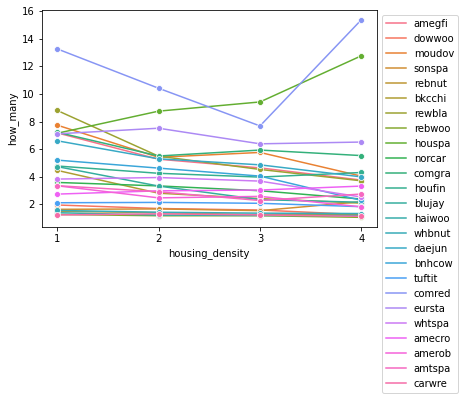

In [31]:
def plot_housing_density(df):
    g = sns.lineplot(x="housing_density", y="how_many", data=df, hue='species_code',  marker='o', ci=None)
    ax = plt.gca()
    #ax.set_title(str(df.index[0][0]))
    plt.legend(loc = "upper left", bbox_to_anchor=(1, 1))
    ax.set_xticks([1,2,3,4])
    plt.show()
# join_df_specieslimited.groupby("species_code").apply(plot_housing_density)
# plt.show()
plot_housing_density(join_df_specieslimited)

In [32]:
# join_df[['loc_id', 'species_code', 'how_many', 'date_time', 'yard_type_pavement', 'yard_type_garden',
#        'yard_type_landsca', 'yard_type_woods', 'yard_type_desert']].groupby(['species_code', 'date_time']).mean()

# Joining with species common names for readability

In [69]:
# def plot_snow_by_genus(df):
#     # grouping by species and snow, averaging counts for each species per snow category
#     average = df.groupby(by=['genus', 'snow_category']).mean()
#     average = average.reindex(index = ['No Snow','< 5 cm','5 to 15 cm', '> 15 cm'], level = 1)
#     fig = plt.gcf()
#     fig.set_size_inches(14, 8)
#     ax = sns.lineplot(data = average, x = average.index.get_level_values(1).to_list(), y = average['how_many'], hue='genus', marker='o').set(title="Avian Genuses at Feeders with Different Snow Levels")
#     plt.legend(loc = "upper left", bbox_to_anchor=(1, 1))
#     return ax
# plot_snow_by_genus(species_limited_df)

### Possible narratives to find in data:
- could look at correlation matrix to predict presence of endangered species / very most common species based off numerous factors
- separate by genus instead of species to look at behavior of broader taxonomic groups (also reduces misidentification and mis-grouping errors in dataset by effectively doing taxonomic roll-up)


## sites_df variables
- `proj_period_id`: Calendar year of end of FeederWatch season
- `yard_type_pavement`: binary variable whether location is pavement (no vegetation)
- `yard_type_garden`: binary variable whether location is a garden/courtyard 
- `yard_type_landsca`: binary variable whether location is a landscaped yard
- \* `yard_type_woods`: binary variable whether location is natural vegetation
- `yard_type_desert`: binary variable whether location is a natural or landscaped desert
- `hab_dcid_woods`: binary variable whether location is within 0.5mi from deciduous woods
- `hab_evgr_woods`: binary variable whether location is within 0.5mi from evergreen woods
- `hab_dcid_woods`: binary variable whether location is within 0.5mi from deciduous woods
- `hab_mixed_woods`: binary variable whether location is within 0.5mi from mixed deciduous-evergreen woods
- `hab_orchard`: binary variable whether location is within 0.5mi from an orchard
- \* `hab_park`: binary variable whether location is within 0.5mi from a park
- \* `hab_water_fresh`: binary variable whether location is within 0.5mi from fresh water
- `hab_water_salt`: binary variable whether location is within 0.5mi from salt water
- * `hab_residential`: binary variable whether location is within 0.5mi from a residential area
- \* `hab_industrial`: binary variable whether location is within 0.5mi from an industrial or commercial area
- `hab_agricultural`: binary variable whether location is within 0.5mi from an agricultural fields
- `hab_desert_scrub`: binary variable whether location is within 0.5mi from a desert or scrub
- `hab_young_woods`: binary variable whether location is within 0.5mi from an secondary growth woods
- `hab_swamp`: binary variable whether location is within 0.5mi from a swamp (wooded)
- `hab_marsh`: binary variable whether location is within 0.5mi from a marsh
- `evgr_trees_atleast`: Minimum number of evergreen trees within the count area
- `evgr_shrbs_atleast`: Minimum number of evergreen shrubs within the count area
- `dcid_trees_atleast`: Minimum number of deciduous trees within the count area
- `dcid_shrbs_atleast`: Minimum number of deciduous shrubs within the count area
- `fru_trees_atleast`: Minimum number of fruit trees within the count area
- `cacti_atleast`: Minimum number of cacti within the count area
- `brsh_piles_atleast`: Minimum number of brush piles within the count area
- `water_srcs_atleast`: Minimum number of water sources within the count area
- `bird_baths_atleast`: Minimum number of bird baths within the count area
- `nearby_feeders`: binary variable whether other feeders (aside from those maintained by participant) within 90m of the count site
- `squirrels`: binary variable whether squirrels take food from the feeders at least 3 times a week
- `cats`: binary variable whether cats are active within 30m of the feeder for at least 30 min 3 times a week
- `dogs`: binary variable whether dogs are active within 30m of the feeder for at least 30 min 3 times a week
- `humans`: binary variable whether humans are active within 30m of the feeder for at least 30 min 3 times a week
- \* `housing_density`: Participant-defined description of the housing density of the neighborhood, where 1 = "rural", 2 = "rural/suburban", 3 = "suburban", 4 = "urban"
- `fed_yr_round`: binary variable whether participant provides food year-round
- `fed_in_jan`, `fed_in_feb`, ... `fed_in_nov`, `fed_in_dec`: binary variables indicating which months of the year participants provide food
- `numfeeders_suet`: continuous variable indicating number of suet feeders
- `numfeeders_ground`: continuous variable indicating number of ground feeders
- `numfeeders_hanging`: continuous variable indicating number of hanging feeders
- `numfeeders_platfrm`: continuous variable indicating number of platform feeders
- `numfeeders_humming`: continuous variable indicating number of sugar water feeders
- `numfeeders_water`: continuous variable indicating number of water dispensers
- `numfeeders_thistle`: continuous variable indicating number of thistle feeders
- `numfeeders_fruit`: continuous variable indicating number of fruit feeders
- `numfeeders_hopper`: continuous variable indicating number of hopper feeders
- `numfeeders_tube`: continuous variable indicating number of tube feeders
- `numfeeders_other`: continuous variable indicating number of other feeder types not included already
- \* `population_atleast`: categorical variable expressing participant estimated population of city or town
- `count_area_size_sq_m_atleast`: categorical variable expressing participant estimated area of survey site